In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import awkward as ak
import seaborn as sn
import pandas as pd
from fast_histogram import histogram2d
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [83]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *
from imcal import plot_conf_matrix

In [84]:
#sn.set_palette("Paired", int(N_LABELS + n_sph_LABELS))
sn.set_theme(context="notebook", style="white", palette="Paired", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)
line_styles = ["-", "--", "-", "--", "-", "--"]

In [85]:
LABELS = ["BH_n5_M8", "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"]
PLOT_LABELS = ["BH_n5_M8", "SPH_9TeV"]
DATAPATHS = [f"/disk/atlas3/data_MC/delphes/{label}_10000events.root:Delphes" for label in LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/delphes/{label}_3000events.root:Delphes" for label in LABELS]

N_LABELS = len(LABELS)
N_EVENTS = 10000
N_TEST_EVENTS = 3000

BH = 0
SPH = 1

In [86]:
def load_data(rootfile:str, N_EVENTS:int, branch:str, keys:list):
    """
    Loads the data as awkward array. Opens the file and extracts the data before closing it again.
    """
    with uproot.open(rootfile) as file:
        valid_list = [key in file.keys() for key in keys]
        if valid_list and N_EVENTS>0:
            arr = file[branch].arrays(keys, library="ak", how="zip")[0:N_EVENTS]
            return arr[branch]
        elif valid_list and N_EVENTS<0:
            arr = file[branch].arrays(keys, library="ak", how="zip")
            return arr[branch]
        else:
            print(keys[not(valid_list)], " not present in data.")



jets = [load_data(path, N_EVENTS, "Jet", 
                        ["Jet.PT"])
                        for path in DATAPATHS]
              
met = [load_data(path, N_EVENTS, "MissingET", 
                        ["MissingET.MET"])
                        for path in DATAPATHS]

electrons = [load_data(path, N_EVENTS, "Electron", 
                        ["Electron.PT","Electron.Charge"])
                        for path in DATAPATHS]

muons = [load_data(path, N_EVENTS, "Muon", 
                        ["Muon.PT", "Muon.Charge"])
                        for path in DATAPATHS]

photons = [load_data(path, N_EVENTS, "Photon", 
                        ["Photon.PT"])
                        for path in DATAPATHS]




In [87]:
#Extracting data for plotting from jets
def jet_data (jets):
    jets_padded = [ak.pad_none(item, 1, axis=-1) for item in jets]
    n_jets = [np.array([len(event) for event in item.PT]) for item in jets]
    jet1_PT = [ak.to_numpy(item.PT[:,0]/1000) for item in jets_padded]
    return jets, n_jets, jet1_PT

#Extracting data for plotting from particle data
def multiplicity(photons, electrons, muons):
    n_photons = [[len(event) for event in item.PT] for item in photons]
    n_electrons = [[len(event) for event in item.PT] for item in electrons]
    #separate muons by charge
    muons_neg = [item[item.Charge < 0] for item in muons]
    muons_pos = [item[item.Charge > 0] for item in muons]
    n_muons_neg = [np.array([len(event) for event in item.PT]) for item in muons_neg]
    n_muons_pos = [np.array([len(event) for event in item.PT]) for item in muons_pos]
    n_muons = [np.array([len(event) for event in item.PT]) for item in muons]
    return n_photons, n_electrons, n_muons_neg, n_muons_pos, n_muons 

#Asymmetry
def asymmetry(pos, neg, total):
    idx = np.flatnonzero(total)
    #pos, neg, total = pos[idx], neg[idx], total[idx]
    total[idx] = (pos[idx]-neg[idx])/total[idx]
    return(total)

def calculate_ST(N_LABELS, jets, muons, electrons, photons, met):
    total_energy = []
    for i in range(N_LABELS):
        jet_sum = np.sum(jets[i].PT, axis=-1)/1000
        muon_sum = np.sum(muons[i].PT, axis=-1)/1000
        electron_sum = np.sum(electrons[i].PT, axis=-1)/1000
        photon_sum = np.sum(photons[i].PT, axis=-1)/1000
        met_sum = np.sum(met[i].MET, axis=-1)/1000
        ST_i = np.array(jet_sum + muon_sum + electron_sum + photon_sum + met_sum)
        total_energy.append(ST_i)
    return total_energy

In [88]:
#Extracting data for plotting from jets
jets, n_jets, jet1_PT = jet_data(jets)
n_photons, n_electrons, n_muons_neg, n_muons_pos, n_muons = multiplicity(photons, electrons, muons)
muon_asymmetry = []
for i in range(N_LABELS):
    muon_asymmetry.append(asymmetry(n_muons_pos[i], n_muons_neg[i], n_muons[i]))
total_energy = calculate_ST(N_LABELS, jets, muons, electrons, photons, met)

#Saving data to dataframes
fields = ["n_jets", "jet1_PT", "muon_asymmetry", "total_energy"]
bh_df = pd.DataFrame(dict(zip(fields, [n_jets[BH], jet1_PT[BH], muon_asymmetry[BH], total_energy[BH]])))
sph_df = pd.DataFrame(dict(zip(fields, [n_jets[SPH], jet1_PT[SPH], muon_asymmetry[SPH], total_energy[SPH]])))

In [89]:
#Make cut
def remove_none(array):
        none_arg = ak.is_none(array)
        not_none_arg = [not item for item in none_arg]
        array = array[not_none_arg]
        return array

def cut(features, cut_feature, cut_val, a, b):
    for feature in features:
        feature[a] = feature[a][cut_feature[a] <= cut_val]
        feature[b] = feature[b][cut_feature[b] > cut_val]
        feature[a] = remove_none(feature[a])
        feature[b] = remove_none(feature[b])
    
    return features
data = [jets, met, electrons, muons, photons]

Text(0.5, 1.0, 'First jet $p_{T}$, KDE')

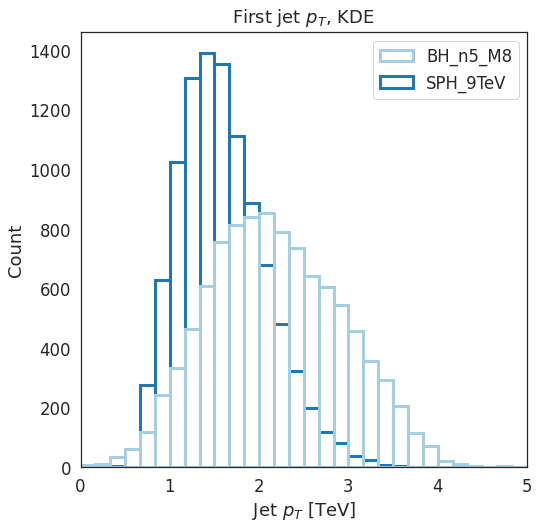

In [90]:
#jet information
fig, ax = plt.subplots(ncols=1, figsize=(8,8))
sn.histplot(dict(zip(PLOT_LABELS, [bh_df["jet1_PT"], sph_df["jet1_PT"]])), ax = ax, bins=30, binrange=[0, 5], multiple="layer", 
            stat="count", linewidth=3, fill=False)

ax.set_xlabel(r"Jet $p_{T}$ [TeV]")
ax.set_xlim(0, 5)
ax.set_title(r"First jet $p_{T}$, KDE", pad=10)


In [91]:
#Make cut
jet1_cut = 2
jet1_order = [SPH, BH]
#data = cut(data, jet1_PT, jet1_cut, SPH, BH)


In [92]:
sph_df = sph_df[sph_df["jet1_PT"] <= 2]
bh_df = bh_df[bh_df["jet1_PT"] > 2]

Text(0.5, 1.0, 'First jet $p_{T}$, KDE')

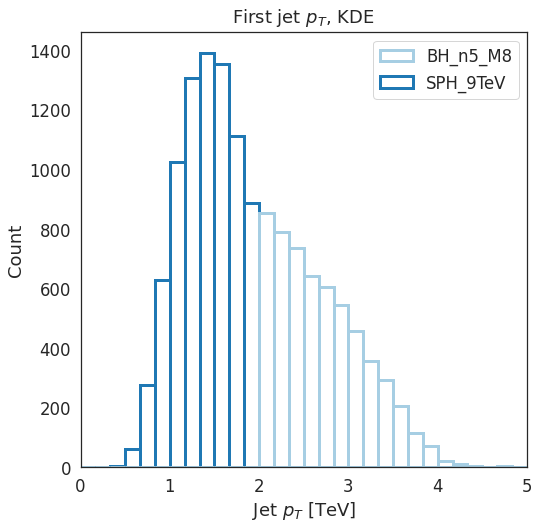

In [93]:
#jet information
fig, ax = plt.subplots(ncols=1, figsize=(8,8))
sn.histplot(dict(zip(PLOT_LABELS, [bh_df["jet1_PT"], sph_df["jet1_PT"]])), ax = ax, bins=30, binrange=[0, 5], multiple="layer", 
            stat="count", linewidth=3, fill=False)

ax.set_xlabel(r"Jet $p_{T}$ [TeV]")
ax.set_xlim(0, 5)
ax.set_title(r"First jet $p_{T}$, KDE", pad=10)


[]

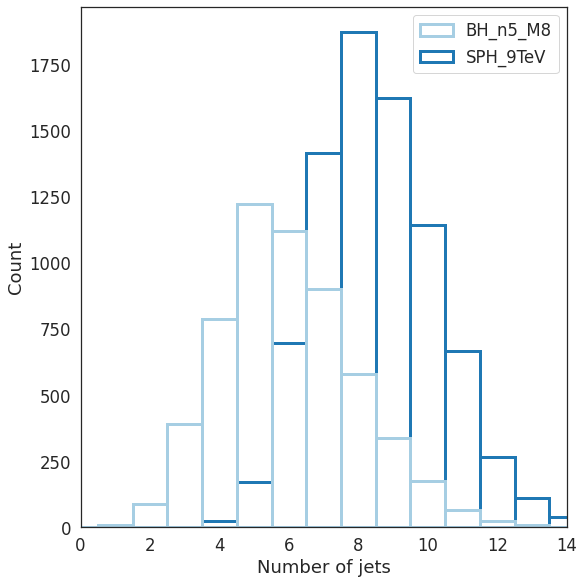

In [94]:
#jet multiplicity
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), layout="constrained")

sn.histplot(dict(zip(PLOT_LABELS, [bh_df["n_jets"], sph_df["n_jets"]])), ax = ax, binwidth=1.0, binrange=[-0.5, 14.5], 
            multiple="layer", stat="count", linewidth=3, fill=False)

ax.set_xlabel("Number of jets")
ax.set_xlim(0, 14)

plt.plot()

In [95]:
n_jet_cut = 7
n_jet_order = [BH, SPH]
#data = cut(data, n_jets, 7, BH, SPH)

bh_df = bh_df[bh_df["n_jets"] <= n_jet_cut]
sph_df = sph_df[sph_df["n_jets"] > n_jet_cut]


[]

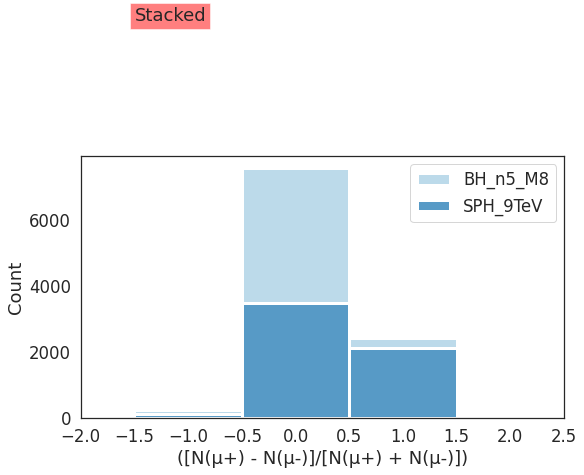

In [96]:
#Asymmetry
fig, ax = plt.subplots(ncols=1, figsize=(8, 6), layout="constrained")

sn.histplot(dict(zip(PLOT_LABELS, [bh_df["muon_asymmetry"], sph_df["muon_asymmetry"]])), ax = ax, binwidth=1, binrange=[-1.5, 1.5], 
            multiple="stack", stat="count", linewidth=3, fill=True)

ax.text(-1.5, 12000, "Stacked", bbox=dict(facecolor='red', alpha=0.5))
ax.set_xlabel(r"([N(μ+) - N(μ-)]/[N(μ+) + N(μ-)])")
ax.set_xlim(-2, 2.5)
#ax.set_ylim(0, 400)

plt.plot()

In [97]:
asymmetry_cut = 0
asymmetry_order = [BH, SPH]
#data = cut(data, muon_asymmetry, asymmetry_cut, BH, SPH)

bh_df = bh_df[bh_df["muon_asymmetry"] <= asymmetry_cut]
sph_df = sph_df[sph_df["muon_asymmetry"] > asymmetry_cut]


Text(0.5, 0, 'ST [TeV]')

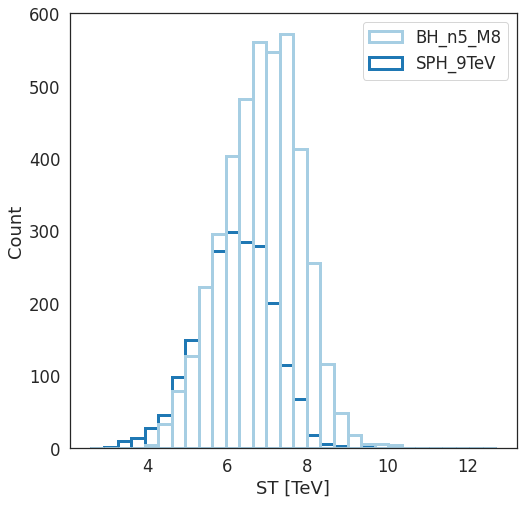

In [98]:
#ST
fig, ax = plt.subplots(ncols=1, figsize=(8,8))
sn.histplot(dict(zip(PLOT_LABELS, [bh_df["total_energy"], sph_df["total_energy"]])), ax = ax, bins=30, multiple="layer", 
            stat="count", linewidth=3, fill=False)

ax.set_xlabel(r"ST [TeV]")
#ax.set_xlim(0, 5)


In [99]:
ST_cut = 7
ST_order = [SPH, BH]
#data = cut(data, total_energy, 7, SPH, BH)


bh_df = bh_df[bh_df["total_energy"] > ST_cut]
sph_df = sph_df[sph_df["total_energy"] <= ST_cut]


In [100]:

jets = [load_data(path, N_TEST_EVENTS, "Jet", 
                        ["Jet.PT", "Jet.Eta", "Jet.Phi"])
                        for path in TEST_DATAPATHS]
              
met = [load_data(path, N_TEST_EVENTS, "MissingET", 
                        ["MissingET.MET", "MissingET.Eta", "MissingET.Phi"])
                        for path in TEST_DATAPATHS]

electrons = [load_data(path, N_TEST_EVENTS, "Electron", 
                        ["Electron.PT", "Electron.Eta", "Electron.Phi", "Electron.Charge"])
                        for path in TEST_DATAPATHS]

muons = [load_data(path, N_TEST_EVENTS, "Muon", 
                        ["Muon.PT", "Muon.Eta", "Muon.Phi", "Muon.Charge"])
                        for path in TEST_DATAPATHS]

photons = [load_data(path, N_TEST_EVENTS, "Photon", 
                        ["Photon.PT", "Photon.Eta", "Photon.Phi"])
                        for path in TEST_DATAPATHS]


In [101]:
#Extracting data for plotting from jets
jets, n_jets, jet1_PT = jet_data(jets)
n_photons, n_electrons, n_muons_neg, n_muons_pos, n_muons = multiplicity(photons, electrons, muons)
muon_asymmetry = []
for i in range(N_LABELS):
    muon_asymmetry.append(asymmetry(n_muons_pos[i], n_muons_neg[i], n_muons[i]))
total_energy = calculate_ST(N_LABELS, jets, muons, electrons, photons, met)

fields = ["n_jets", "jet1_PT", "muon_asymmetry", "total_energy"]
bh_test_df = pd.DataFrame(dict(zip(fields, [n_jets[BH], jet1_PT[BH], muon_asymmetry[BH], total_energy[BH]])))
sph_test_df = pd.DataFrame(dict(zip(fields, [n_jets[SPH], jet1_PT[SPH], muon_asymmetry[SPH], total_energy[SPH]])))
bh_test_df["event_truth"] = 0
sph_test_df["event_truth"] = 1
test_df = pd.concat([bh_test_df, sph_test_df])

In [102]:
black_holes = test_df[test_df["jet1_PT"] > jet1_cut]
sphalerons = test_df[test_df["jet1_PT"] <= jet1_cut]

black_holes = black_holes[black_holes["n_jets"] <= n_jet_cut]
sphalerons = sphalerons[sphalerons["n_jets"] > n_jet_cut]

black_holes = black_holes[black_holes["muon_asymmetry"] <= asymmetry_cut]
sphalerons = sphalerons[sphalerons["muon_asymmetry"] > asymmetry_cut]

black_holes = black_holes[black_holes["total_energy"] > ST_cut]
sphalerons = sphalerons[sphalerons["total_energy"] <= ST_cut]

black_holes["event_pred"] = 0
sphalerons["event_pred"] = 1

black_holes["correct"] = np.where(black_holes["event_pred"] == black_holes["event_truth"], 1, 0)
sphalerons["correct"] = np.where(sphalerons["event_pred"] == sphalerons["event_truth"], 1, 0)

truth = list(black_holes["event_truth"]) + list(sphalerons["event_truth"])
preds = list(black_holes["event_pred"]) + list(sphalerons["event_pred"])

confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

In [103]:
print("Number of black hole events: ", len(black_holes))
print("Number of sphaleron events: ", len(sphalerons))


Number of black hole events:  667
Number of sphaleron events:  542


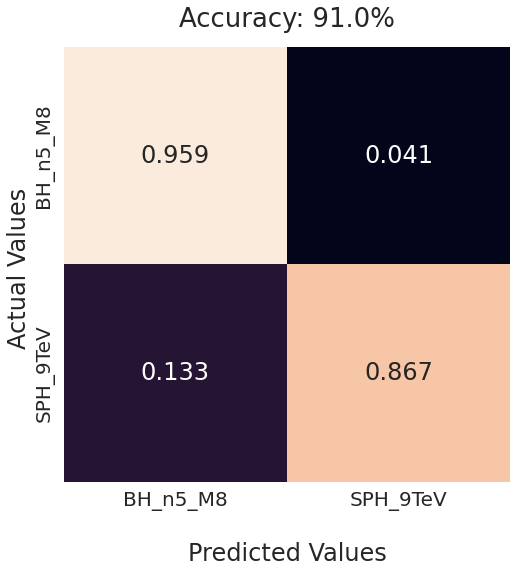

In [104]:
plot_conf_matrix(confusion, accuracy, PLOT_LABELS)